# Skill Factory: Credit Scoring model 

## EDA

In [1]:
from pandas import Series
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve, f1_score

# BASE_DIR = '/kaggle/input/sf-dst-scoring/'
BASE_DIR = './'

def read_csv(file_name):
    return pd.read_csv(BASE_DIR + file_name)

In [2]:
# Loading data
df = read_csv('train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [3]:
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


## Agenda

- Fill NA
- Display histogram for each column
- Display correlation heatmap
- Split columns by type {number, categorical, binary}
- Iteratively:
    - encode binary columns
    - encode categorical columns
    - optionally log features
    - normalise all columns
    - display top columns affecting target column
    - filter out columns not affecting target column
    - display correlation heat map
    - filter out correlated with each other columns
    - train Logistic Regressor using default parameters
    - evaluate model performance
    - develope and add new features (application day of week, day of month, month of year, season, normalized by region reting (age, good work, score bki, income, foreign passport))

## Fill NA

In [8]:
df.isna().sum()

client_id           0
app_date            0
education           0
sex                 0
age                 0
car                 0
car_type            0
decline_app_cnt     0
good_work           0
score_bki           0
bki_request_cnt     0
region_rating       0
home_address        0
work_address        0
income              0
sna                 0
first_time          0
foreign_passport    0
default             0
dtype: int64

In [9]:
print('Education missing values percentage: {}%'.format(round(df['education'].isna().sum() / len(df) * 100, 2)))

Education missing values percentage: 0.0%


### Checking if it is safe to drop records with undefined education. Decision to use `UNDEF` value for undefined education.

In [10]:
df_undefined_edu = df[df['education'].isnull()]
df_defined_edu = df[df['education'].notnull()]
print('Mean default in group with undefined education: {}%'.format(round(df_undefined_edu['default'].mean() * 100, 2)))
print('Mean default in group with defined education: {}%'.format(round(df_defined_edu['default'].mean() * 100, 2)))
print('Mean default in train data set: {}%'.format(round(df['default'].mean() * 100, 2)))
df['education'] = df['education'].fillna('UNDEF')

Mean default in group with undefined education: nan%
Mean default in group with defined education: 12.7%
Mean default in train data set: 12.7%


### Building preprocessing pipeline to apply to both train and test data sets:

In [13]:
class DataSet:
    
    def __init__(self, data_set, C=1, solver='lbfgs', max_depth=2, max_features='auto'):
        # defensive copy
        self.data_set = data_set.copy()
        self._reset_column_names()
        self.should_oversample = False
        self.should_normalise = False
        self.scaler = StandardScaler()
        self.label_encoders = {}
        self.C = C
        self.solver = solver
        self.max_depth = max_depth
        self.max_features = max_features
        

    def preprocess(self):
        self._reset_column_names()
        self.fillna()
        self.oversample()
        self.normalise()
        self.add_features()
        self.add_log_features()
        self.add_binary_features()
        self.add_categorical_features()
        self.add_date_features()
        self.add_region_derivatives()


    def fillna(self):
        
        # undefined column becomes value of categorical feature
        self.data_set['education'] = self.data_set['education'].fillna('UNDEF')
    
    
    def oversample(self):
        self.should_oversample = True
        
    
    def normalise(self):
        self.should_normalise = True
        
    
    def add_features(self):
        self.num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'score_bki', 'region_rating']
    
    def add_log_features(self):
        log_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']
        for column in log_cols:
            new_column_name = column + '_log'
            self.data_set[[new_column_name]] = np.log(self.data_set[[column]] + 1)
            self.num_cols.append(new_column_name)
            
        # after reviewing features performance some have to be tremoved to avoid correlation
        # cols_to_remove = ['age', 'decline_app_cnt', 'income', 'bki_request_cnt_log']
        cols_to_remove = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']
        self.data_set = self.data_set.drop(cols_to_remove, axis=1)
        for col in cols_to_remove:
            self.num_cols.remove(col)
            
    
    def add_binary_features(self):
        for column in self.bin_cols:
            if column in self.label_encoders:
                self.data_set[column] = self.label_encoders[column].transform(self.data_set[column])
            else:
                self.label_encoders[column] = LabelEncoder()
                self.data_set[column] = self.label_encoders[column].fit_transform(self.data_set[column])
            self.num_cols.append(column)
            # for column in self.bin_cols:
            #     print(dict(enumerate(self.label_encoders[column].classes_)))
    
    def add_categorical_features(self):
        if hasattr(self, 'one_hot_encoder'):
            X_cat = self.one_hot_encoder.transform(self.data_set[self.cat_cols].values)
        else:
            self.one_hot_encoder = OneHotEncoder(sparse = False)
            X_cat = self.one_hot_encoder.fit_transform(self.data_set[self.cat_cols].values)
            
        self.data_set = self.data_set.drop(self.cat_cols, axis=1)
        for i in range(len(self.cat_cols)):
            col = self.cat_cols[i];
            self.data_set[col] = X_cat[:,i]
            self.num_cols.append(col)
            
    def add_date_features(self):
        print('TODO: add_date_features')
    
    def add_region_derivatives(self):
        for col in self.num_cols.copy():
            excluded = ['region_rating', 'first_time', 'education', 'sex', 'decline_app_cnt', 'bki_request_cnt', 'decline_app_cnt_log', 
                        'age_log', 'bki_request_cnt_log', 'car', 'car_type', 'foreign_passport', 'good_work', 'home_address', 'sna']
#             excluded = ['region_rating']
            if col in excluded:
                continue

            excluded = ['income', 'work_address', 'score_bki', 'income_log', 'age_log', 'car', 'car_type', 
                        'foreign_passport', 'good_work', 'education', 'home_address']
#             excluded = []
            if col not in excluded:
                new_col = col + '_by_region_rating'
                self.data_set[new_col] = self.data_set[col] / self.data_set['region_rating']
                self.num_cols.append(new_col)
            
            excluded = ['decline_app_cnt_log', 'sex', 'first_time', 'bki_request_cnt_log', 'income_log', 'age_log', 'sna', 'work_address']
#             excluded = []
            if col not in excluded:
                new_col = col + '_x_region_rating'
                self.data_set[new_col] = self.data_set[col] * self.data_set['region_rating']
                self.num_cols.append(new_col)
            
        for col in ['decline_app_cnt_log']:
            self.num_cols.remove(col)
    
    
    def hist(self):
        for column in self.bin_cols:
            self._plot(self.data_set[column].value_counts(), column)
        
        for column in self.cat_cols:
            self._plot(self.data_set[column].value_counts(), column)
        
        for column in self.num_cols:
            self.data_set[[column]].hist()
    
    
    def corr(self):
        plt.figure(figsize = (16,16))
        sns.heatmap(self.data_set[self.num_cols].corr().abs(), vmin=0, vmax=1)
    
    
    def features(self):
        imp_num = Series(f_classif(self.data_set[self.num_cols], self.data_set['default'])[0], index = self.num_cols)
        imp_num.sort_values(inplace = True)
        imp_num.plot(kind = 'barh', figsize=(10, 10))
    
    
    def train(self):
        X = self.data_set[self.num_cols]
        y = self.data_set['default']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
        
        X_train, y_train = self._oversample_on_demand(X_train, y_train)
        
        X_train, X_test = self._normalise_on_demand(X_train, X_test)
        
        self.model = LogisticRegression(C=self.C, solver=self.solver)
    
        self.model.fit(X_train, y_train)
        
        

#         # запускаем GridSearch на небольшом кол-ве итераций max_iter=50 и с достаточно большой дельтой останова tol1e-3
#         # чтобы получить оптимальные параметры модели в первом приближении
#         model = LogisticRegression(random_state=42)
#         iter_ = 50
#         epsilon_stop = 1e-3
#         param_grid = [
#             {'penalty': ['l1'],
#              'solver': ['liblinear', 'lbfgs'], 
#              'class_weight':['none', 'balanced'], 
#              'multi_class': ['auto','ovr'], 
#              'max_iter':[iter_],
#              'tol':[epsilon_stop]},
#             {'penalty': ['l2'], 
#              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
#              'class_weight':['none', 'balanced'], 
#              'multi_class': ['auto','ovr'], 
#              'max_iter':[iter_],
#              'tol':[epsilon_stop]},
#             {'penalty': ['none'], 
#              'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
#              'class_weight':['none', 'balanced'], 
#              'multi_class': ['auto','ovr'], 
#              'max_iter':[iter_],
#              'tol':[epsilon_stop]},
#         ]
#         gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, cv=5)
#         gridsearch.fit(X_train, y_train)
#         self.model = gridsearch.best_estimator_
#         
#         ##печатаем параметры
#         best_parameters = model.get_params()
#         for param_name in sorted(best_parameters.keys()):
#             print('\t%s: %r' % (param_name, best_parameters[param_name]))
    
    

        
        y_test_pred = self.model.predict(X_test)
        y_train_pred = self.model.predict(X_train)
        
        self.X_test = X_test
        self.y_test = y_test
        self.y_test_pred = y_test_pred
        
        self.X_train = X_train
        self.y_train = y_train
        self.y_train_pred = y_train_pred
        
    
    def score(self):
        self._score('Self prediction: ', self.X_train, self.y_train, self.y_train_pred)
        self._score('Test prediction: ', self.X_test, self.y_test, self.y_test_pred)
    
    
    def predict_and_submit(self, test_df):
        test_ds = DataSet(test_df)
        test_ds.scaler = self.scaler
        test_ds.label_encoders = self.label_encoders
        test_ds.model = self.model
        test_ds.preprocess()
        
        X = test_ds.data_set[test_ds.num_cols]
        if self.should_normalise:
            X = self.scaler.transform(X)
        
        y = test_ds.model.predict(X)
        
        submission = pd.DataFrame()
        submission[['client_id']] = test_ds.data_set[['client_id']]
        submission[['default']] = y
        return submission
        
    
    def _reset_column_names(self):
        self.bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work']
        self.cat_cols = ['education', 'home_address', 'work_address', 'sna', 'first_time']
        self.num_cols = ['score_bki']
        self.other_cols = ['app_date']
    
    
    def _plot(self, value_counts, name):
        plt.figure(figsize=(10,4))
        sns.barplot(value_counts.index, value_counts.values, alpha=0.8)
        plt.title('Top {}'.format(name))
        plt.ylabel('Number of Occurrences', fontsize=12)
        plt.xlabel(name, fontsize=12)
        plt.show()
    
    def _score(self, title, X, y, y_pred):
        probs = self.model.predict_proba(X)
        probs = probs[:,1]

        fpr, tpr, threshold = roc_curve(y, probs)
        roc_auc = roc_auc_score(y, probs)

        plt.figure()
        plt.plot([0, 1], label='Baseline', linestyle='--')
        plt.plot(fpr, tpr, label = 'Regression')
        plt.title((title + 'Logistic Regression ROC AUC = %0.3f') % roc_auc)
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.legend(loc = 'lower right')
        plt.show()
        
        print(title)
        print('Confusion matrix:\n{}\n'.format(confusion_matrix(y, y_pred)))
        print('F1 Score: {}\n'.format(f1_score(y, y_pred)))
    
    def _oversample_on_demand(self, X, y):
        
        if not self.should_oversample:
            return X, y
        
        temp_df = X.copy()
        temp_df['y'] = y
        
        defaulted = temp_df[temp_df['y'] == 1]
        not_defaulted = temp_df[temp_df['y'] == 0]
        disbalance_ratio = int(round(len(not_defaulted) / len(defaulted)))

        for i in range(disbalance_ratio - 1):
            temp_df = temp_df.append(defaulted)
        
        X = temp_df.drop(['y'], axis=1)
        y = temp_df['y']
        
        return X, y
    
    def _normalise_on_demand(self, X_train, X_test):
        
        if not self.should_normalise:
            return X_train, X_test
        
        X_train = self.scaler.fit_transform(X_train)
        X_test = self.scaler.transform(X_test)
        return X_train, X_test
        
            
    

## Iteration #1 – using just one feature `score_bki`

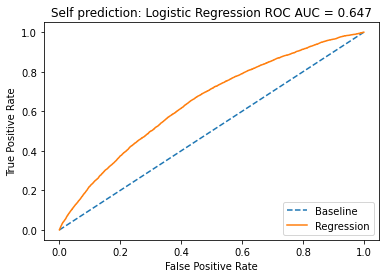

Self prediction: 
Confusion matrix:
[[51491     3]
 [ 7544     1]]

F1 Score: 0.00026493575307987813



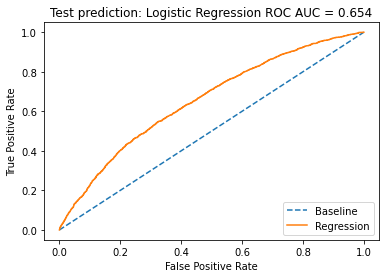

Test prediction: 
Confusion matrix:
[[12933     0]
 [ 1824     3]]

F1 Score: 0.0032786885245901635



In [14]:
ds = DataSet(df)
ds.fillna()
ds.train()
ds.score()

## Iteration #2: Oversampling

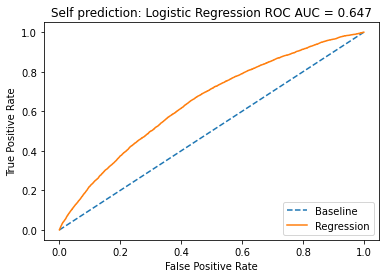

Self prediction: 
Confusion matrix:
[[30547 20947]
 [19915 32900]]

F1 Score: 0.616901989462039



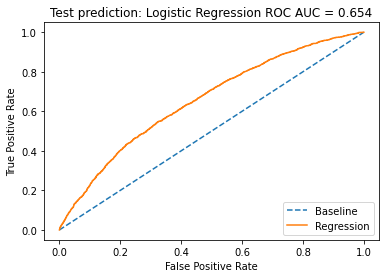

Test prediction: 
Confusion matrix:
[[7704 5229]
 [ 696 1131]]

F1 Score: 0.2762916819347746



In [15]:
ds = DataSet(df)
ds.fillna()
ds.oversample()
ds.train()
ds.score()

## Iteration #3: Normalising numeric features

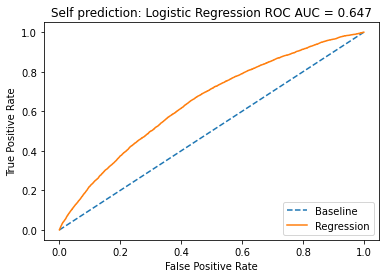

Self prediction: 
Confusion matrix:
[[30547 20947]
 [19915 32900]]

F1 Score: 0.616901989462039



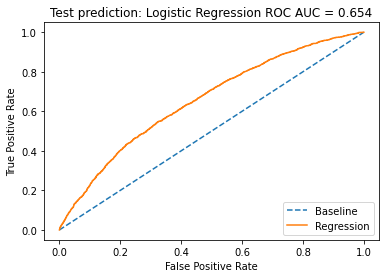

Test prediction: 
Confusion matrix:
[[7704 5229]
 [ 696 1131]]

F1 Score: 0.2762916819347746



In [16]:
ds = DataSet(df)
ds.fillna()
ds.oversample()
ds.normalise()
ds.train()
ds.score()

## Iteration #4: Using all numeric features

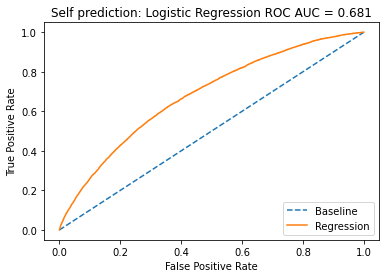

Self prediction: 
Confusion matrix:
[[32362 19132]
 [19173 33642]]

F1 Score: 0.6372254685620661



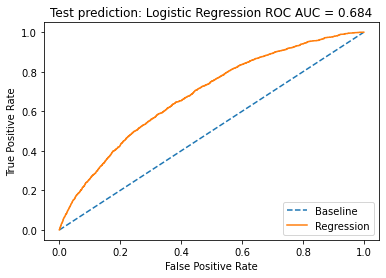

Test prediction: 
Confusion matrix:
[[8124 4809]
 [ 669 1158]]

F1 Score: 0.29715165511932257



In [17]:
ds = DataSet(df)
ds.fillna()
ds.oversample()
ds.normalise()
ds.add_features()
ds.train()
ds.score()

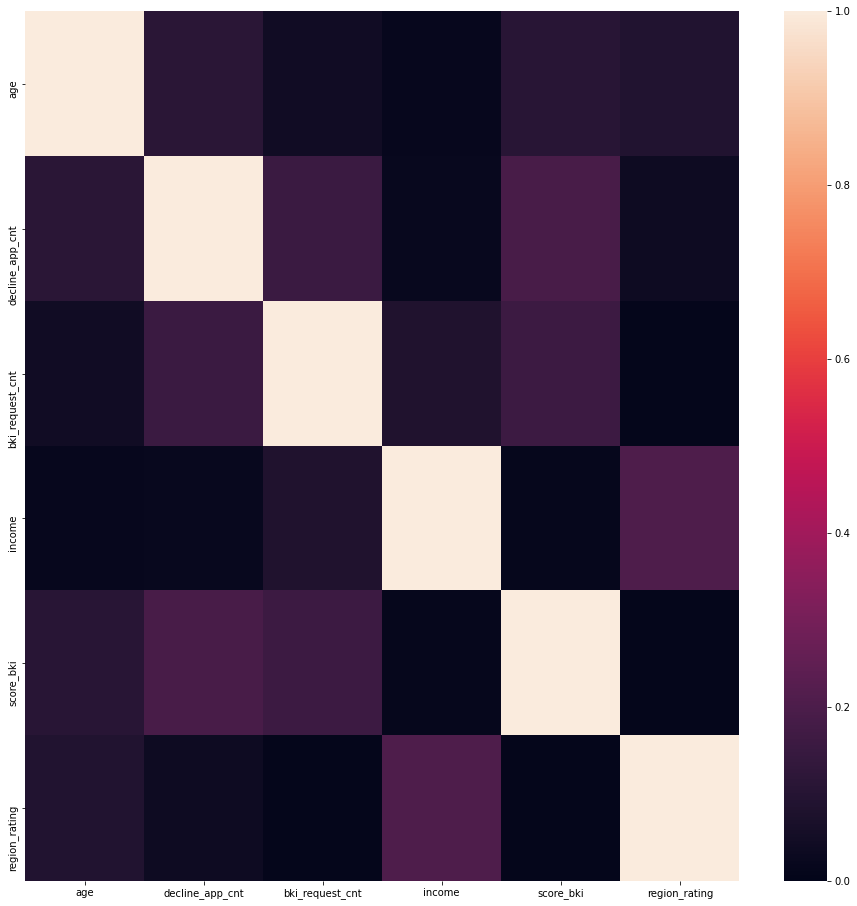

In [18]:
ds.corr()

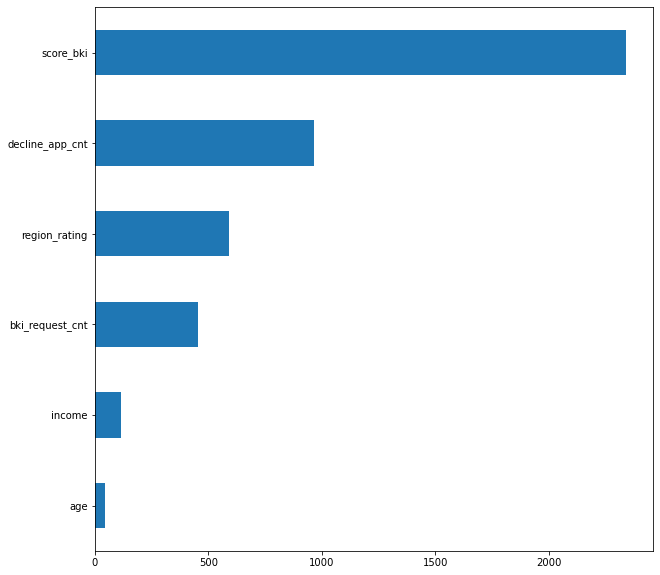

In [19]:
ds.features()

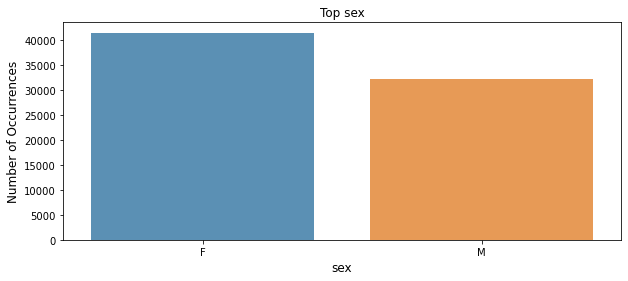

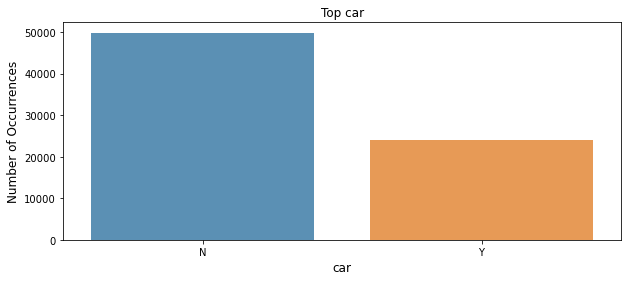

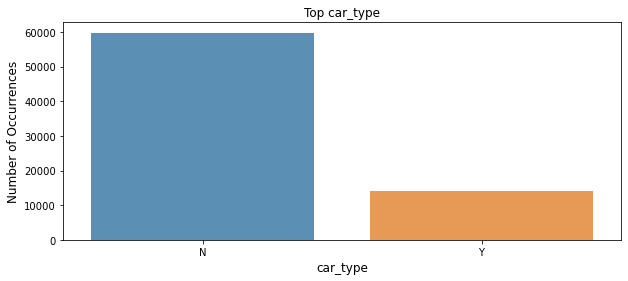

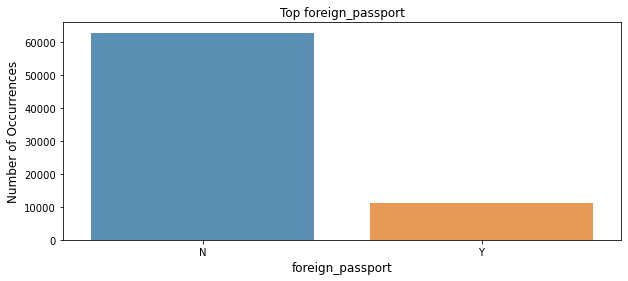

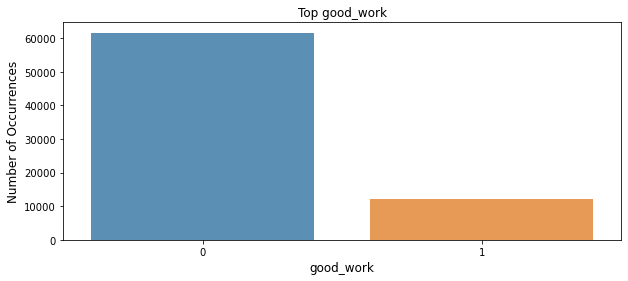

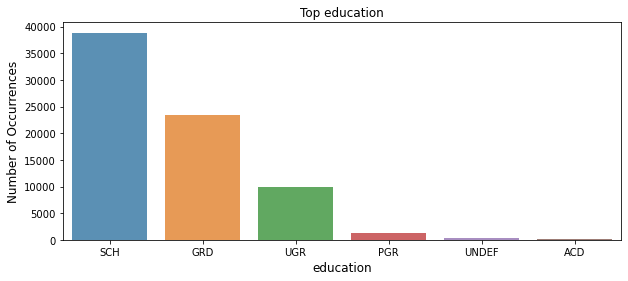

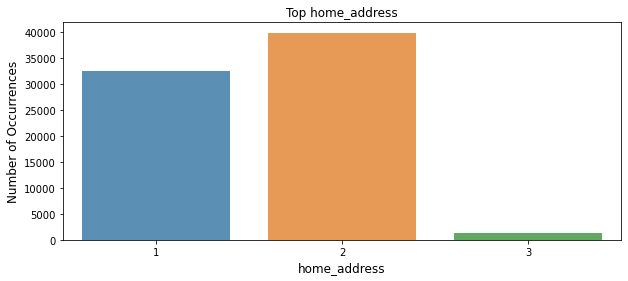

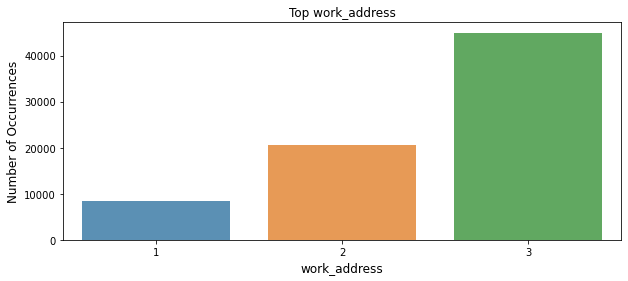

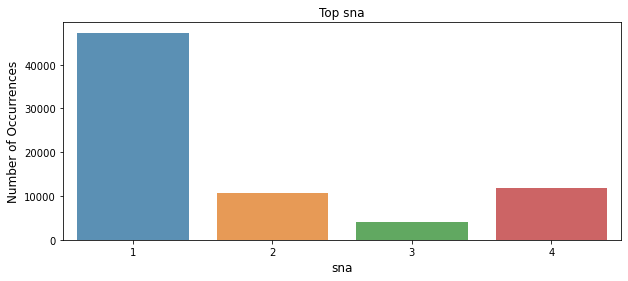

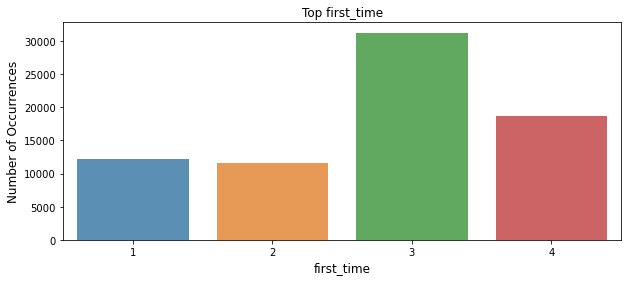

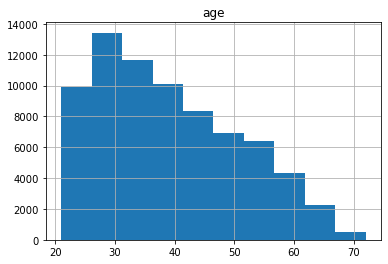

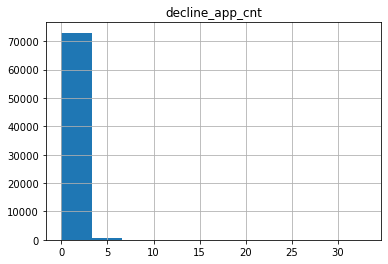

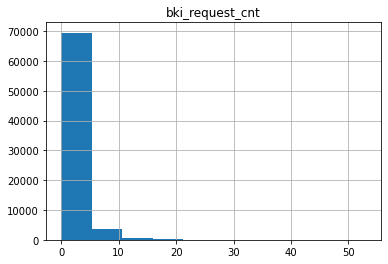

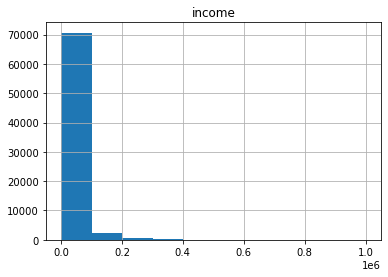

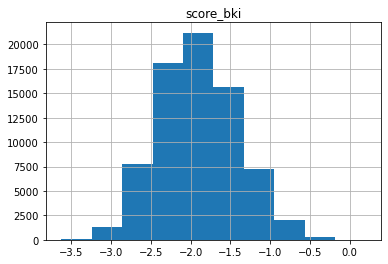

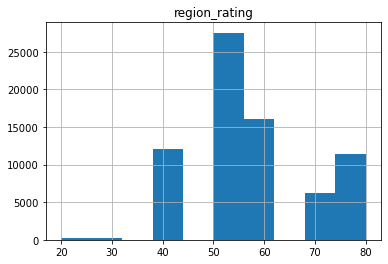

In [20]:
ds.hist()

## Iteration #5: Using log numeric features

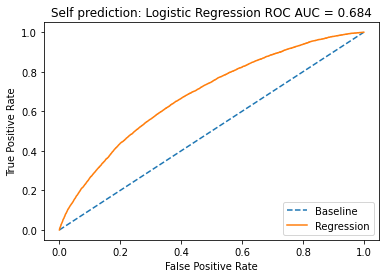

Self prediction: 
Confusion matrix:
[[32398 19096]
 [19145 33670]]

F1 Score: 0.637804150367964



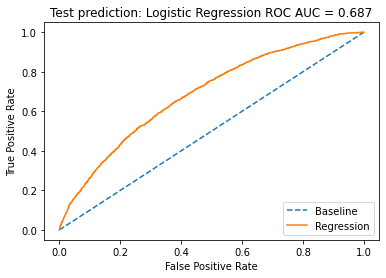

Test prediction: 
Confusion matrix:
[[8163 4770]
 [ 666 1161]]

F1 Score: 0.29930394431554525



In [21]:
ds = DataSet(df)
ds.fillna()
ds.oversample()
ds.normalise()
ds.add_features()
ds.add_log_features()
ds.train()
ds.score()

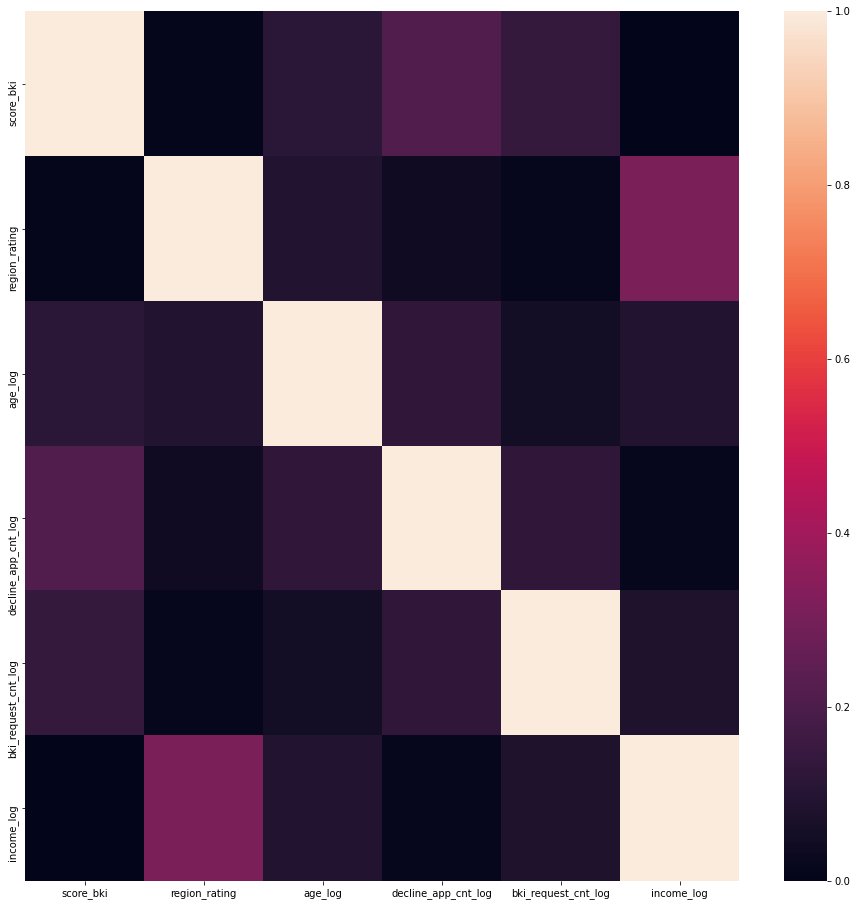

In [22]:
ds.corr()

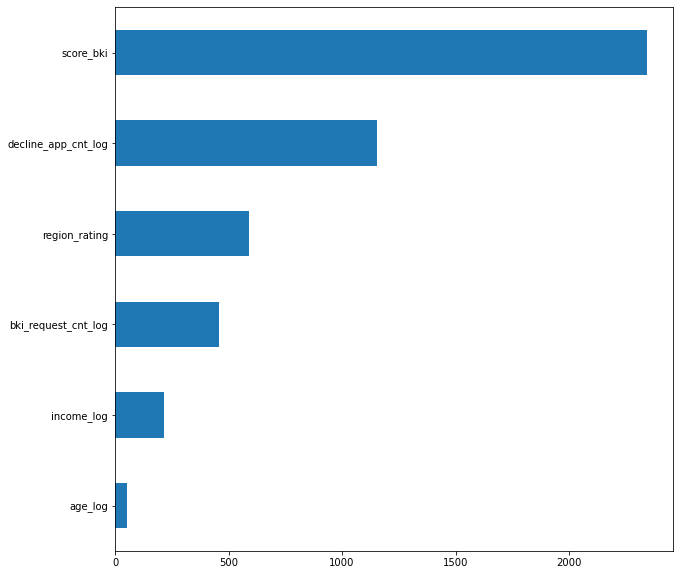

In [23]:
ds.features()

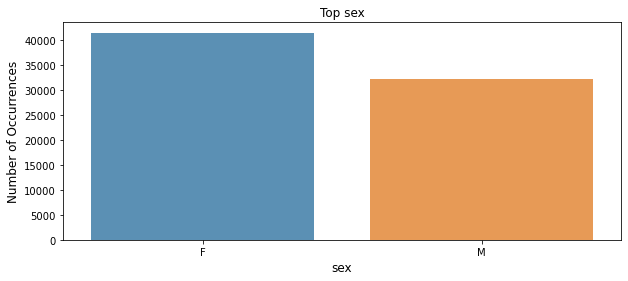

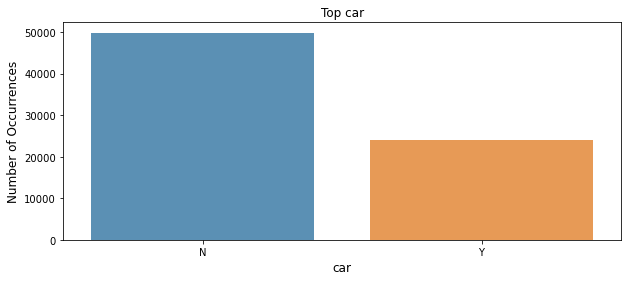

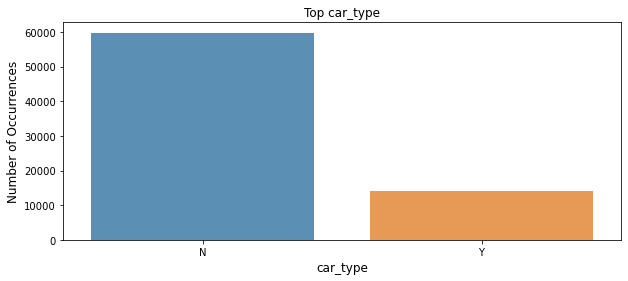

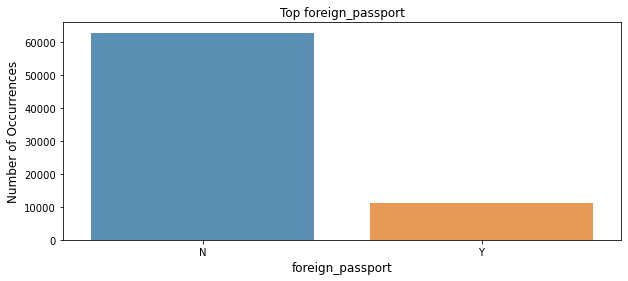

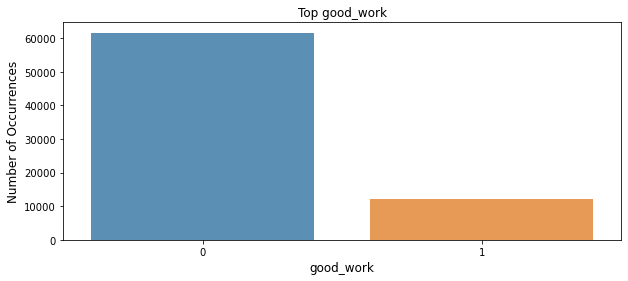

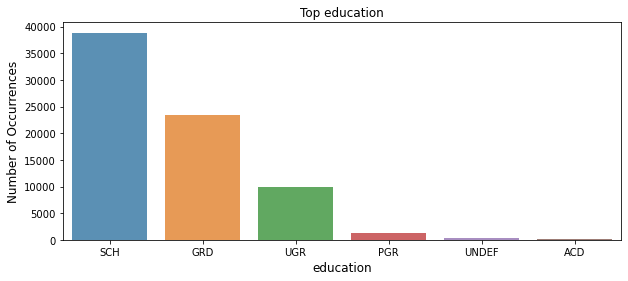

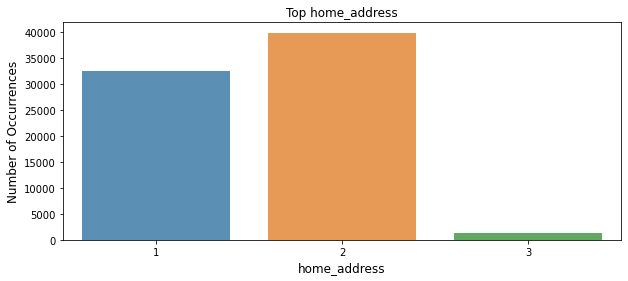

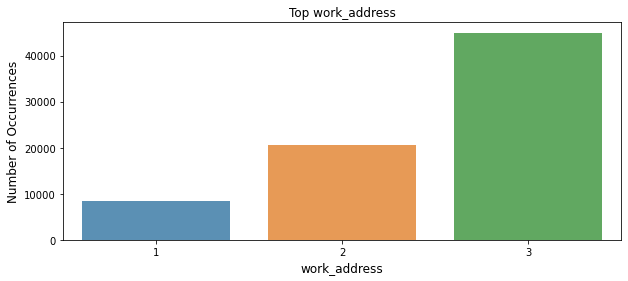

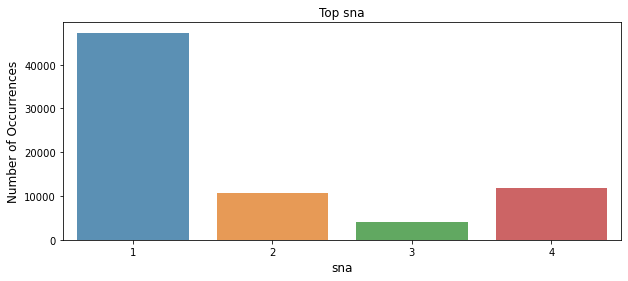

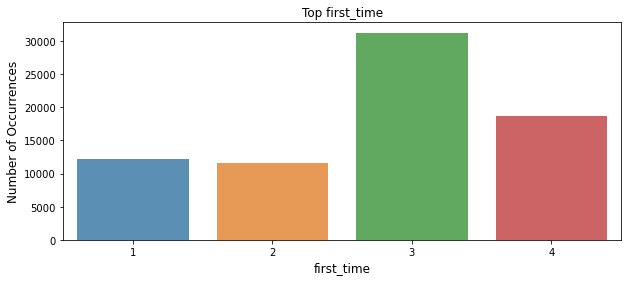

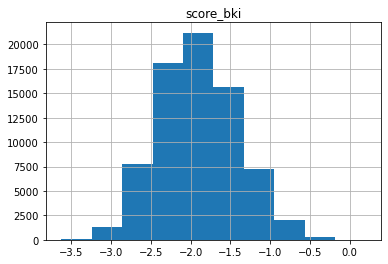

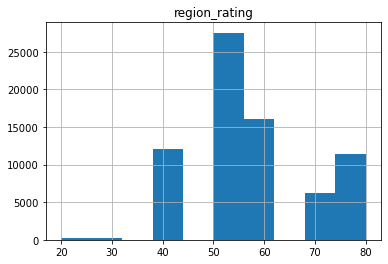

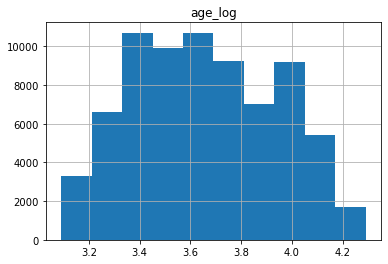

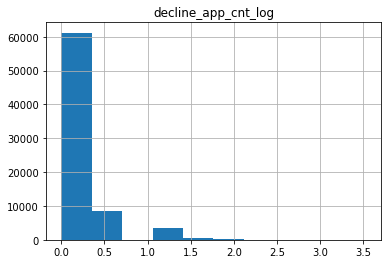

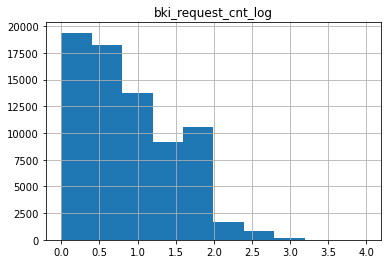

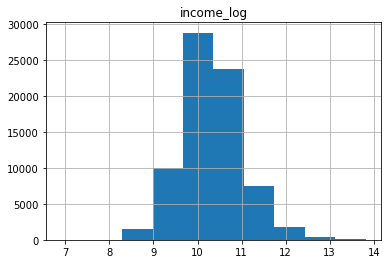

In [24]:
ds.hist()

## Iteration #6: Encoding binary features

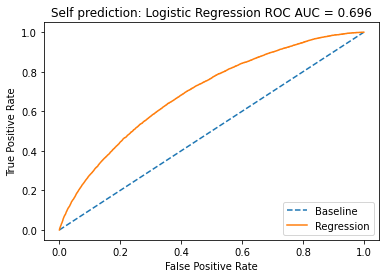

Self prediction: 
Confusion matrix:
[[32226 19268]
 [18207 34608]]

F1 Score: 0.6487520034492132



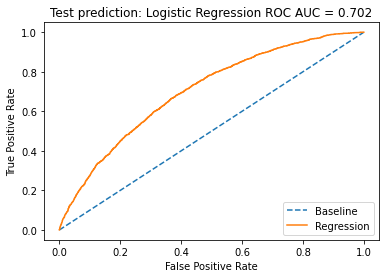

Test prediction: 
Confusion matrix:
[[8222 4711]
 [ 621 1206]]

F1 Score: 0.3114669421487603



In [25]:
ds = DataSet(df)
ds.fillna()
ds.oversample()
ds.normalise()
ds.add_features()
ds.add_log_features()
ds.add_binary_features()
ds.train()
ds.score()

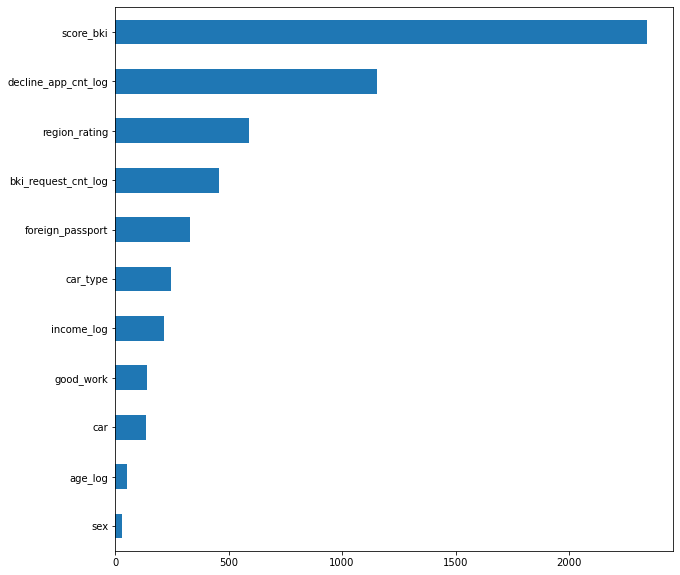

In [26]:
ds.features()

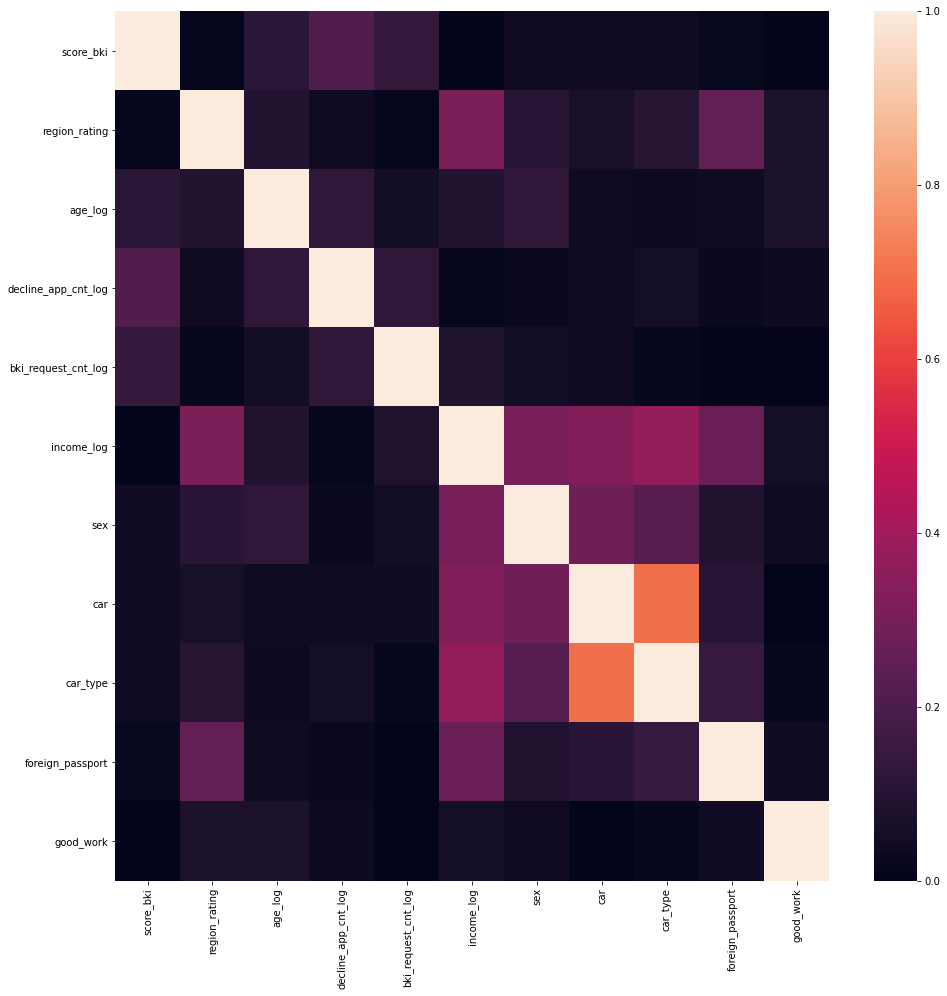

In [27]:
ds.corr()

## Iteration #7: Adding categorical features

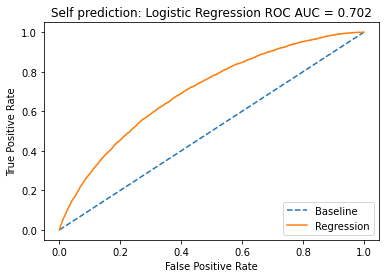

Self prediction: 
Confusion matrix:
[[32271 19223]
 [17675 35140]]

F1 Score: 0.6557315867062269



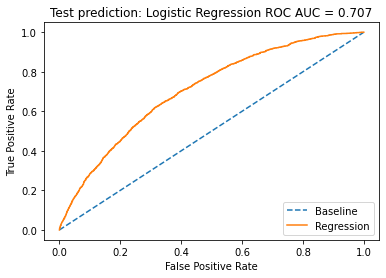

Test prediction: 
Confusion matrix:
[[8155 4778]
 [ 608 1219]]

F1 Score: 0.31160531697341515



In [28]:
ds = DataSet(df)
ds.fillna()
ds.oversample()
ds.normalise()
ds.add_features()
ds.add_log_features()
ds.add_binary_features()
ds.add_categorical_features()
ds.train()
ds.score()

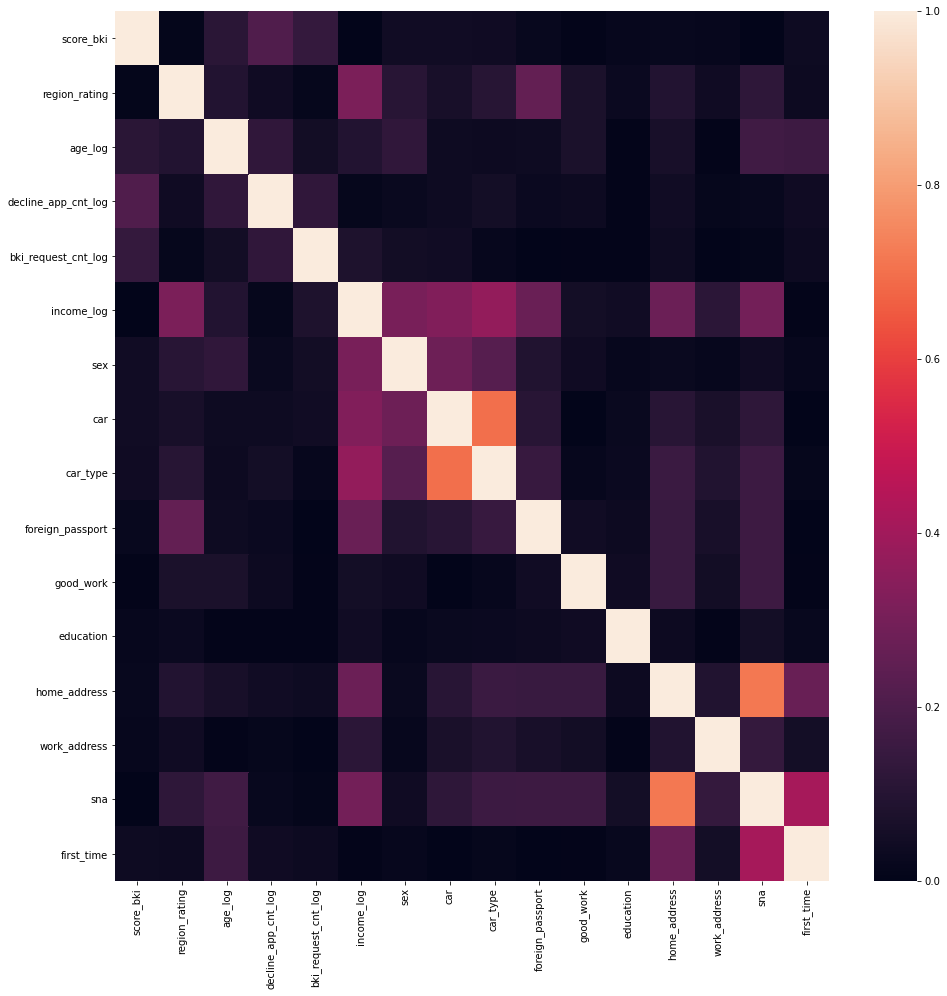

In [29]:
ds.corr()

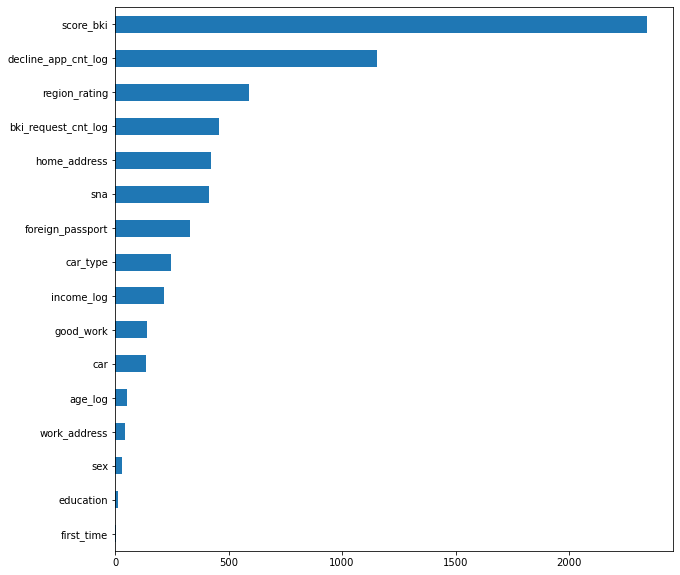

In [30]:
ds.features()

## Iteration #8: Adding application date features

TODO: add_date_features


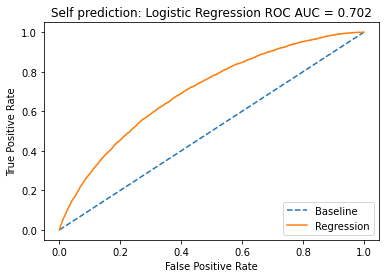

Self prediction: 
Confusion matrix:
[[32271 19223]
 [17675 35140]]

F1 Score: 0.6557315867062269



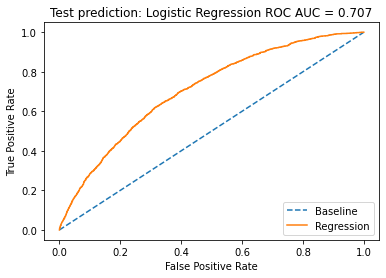

Test prediction: 
Confusion matrix:
[[8155 4778]
 [ 608 1219]]

F1 Score: 0.31160531697341515



In [31]:
ds = DataSet(df)
ds.fillna()
ds.oversample()
ds.normalise()
ds.add_features()
ds.add_log_features()
ds.add_binary_features()
ds.add_categorical_features()
ds.add_date_features()
ds.train()
ds.score()

## Iteration #9: Adding numerical features normalised by region rating

TODO: add_date_features


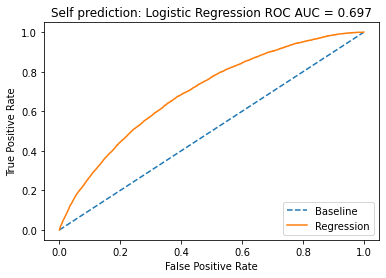

Self prediction: 
Confusion matrix:
[[31454 20040]
 [17136 35679]]

F1 Score: 0.6574713914533695



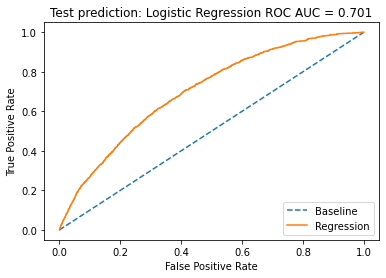

Test prediction: 
Confusion matrix:
[[7959 4974]
 [ 598 1229]]

F1 Score: 0.3061021170610212



In [32]:
ds = DataSet(df, C=21.544346900318832)
ds.fillna()
ds.oversample()
ds.normalise()
ds.add_features()
ds.add_log_features()
ds.add_binary_features()
ds.add_categorical_features()
ds.add_date_features()
ds.add_region_derivatives()
ds.train()
ds.score()

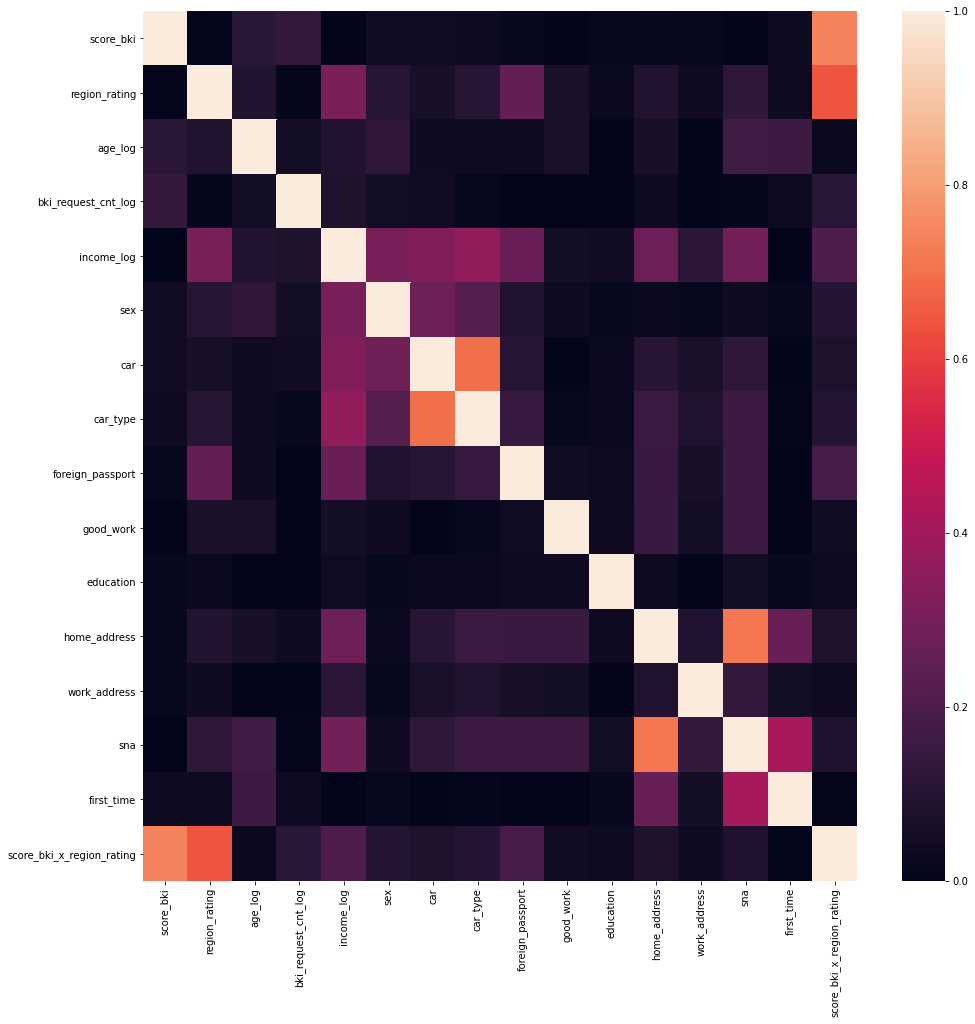

In [33]:
ds.corr()

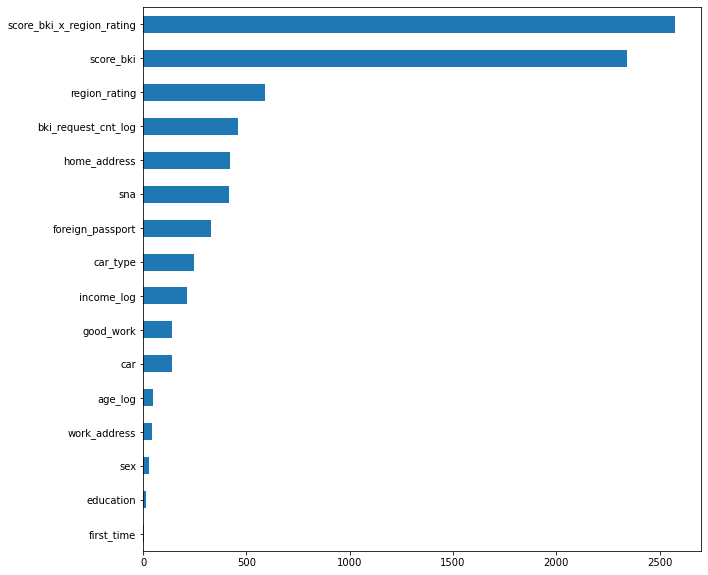

In [34]:
ds.features()

# Publishing results

In [35]:
test_df = read_csv('test.csv')

submission = ds.predict_and_submit(test_df)

TODO: add_date_features


KeyError: "None of [Index(['default'], dtype='object')] are in the [columns]"

In [252]:
submission.to_csv('./submission.csv', index=False)
submission.head(10)
print(submission[['default']].sum())
print(len(submission))


default    15544
dtype: int64
36349


# Testing predict and submit

In [203]:
X = df.drop(['default'], axis=1)
y = df['default']
y_pred = ds.predict_and_submit(X)['default']

print('Confusion matrix:\n{}\n'.format(confusion_matrix(y, y_pred)))
print('F1 Score: {}\n'.format(f1_score(y, y_pred)))

y_pred = np.random.choice([0, 1], size=len(y_pred), p=[.5, .5])
print('Confusion matrix:\n{}\n'.format(confusion_matrix(y, y_pred)))
print('F1 Score: {}\n'.format(f1_score(y, y_pred)))

TODO: add_date_features
Confusion matrix:
[[40143 24284]
 [ 3102  6270]]

F1 Score: 0.31408104994239344

Confusion matrix:
[[32268 32159]
 [ 4684  4688]]

F1 Score: 0.20286029554944934

